# Config and setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.feature_selection import mutual_info_regression # MI score
from sklearn.preprocessing import MinMaxScaler # data scaler module 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

import folium # geocode visualising module
from scipy import stats # statistics module

In [2]:
# loading data (both train and test data)
raw_data = pd.read_csv("/work/ames_housing_dataset/train.csv")
raw_data.drop(['Id'],axis=1, inplace=True)

Matplotlib and seaborn configs

In [3]:
# configs
sns.set(rc={'figure.figsize':(16,8)}) # sets the standard figsize for seaborn

np.random.seed(0) # set seed for reproduceability

# maybe these are needed later:
#pd.set_option('display.max_columns', None) # sets no cap on how many columns are shown 
#pd.set_option('display.max_rows', None)  # # sets no cap on how many rows are shown
#pd.set_option('display.max_colwidth', None) # Removes the maximum width in characters of a column in the repr of a pandas data structure.

# Set Matplotlib defaults settings
#plt.style.use("seaborn-whitegrid")
#plt.rc("figure", autolayout=True)
#plt.rc(
#    "axes",
#    labelweight="bold",
#    labelsize="large",
#    titleweight="bold",
#    titlesize=14,
#   titlepad=10,
#)

# Data Cleaning

In [4]:
data = raw_data.copy() # creating the dataset to be cleaned data set (and drop the Id attribute)

## Dealing with missing values 

This section seeks to clean each attribute holding empty values. First we give an overview of the attributes with missing values

In [5]:
missing_values = data.isnull().sum() # pandas series with count of missing values on every attribute
missing_values = missing_values[missing_values > 0].sort_values(axis=0) # omitting atributes with no missing values and sorting them in ascending order

# code for counting how many attributes have null values
attributes_with_NaN_count = 0
for i in missing_values > 0:
  if i == True:
    attributes_with_NaN_count += 1
print(f"there are {attributes_with_NaN_count} attributes with NaN values")

there are 19 attributes with NaN values


In [6]:
dataframe_missing = data[missing_values.index] # creates a dataframe with just the attributes that contains missing values
# dataframe_missing.info() # gets info on the dataframe

In [7]:
dataframe_missing.isna().sum().sum() # total number of missing data points

6965

In [8]:
dataframe_missing.columns

Index(['Electrical', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2', 'GarageCond',
       'GarageQual', 'GarageFinish', 'GarageType', 'GarageYrBlt',
       'LotFrontage', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature',
       'PoolQC'],
      dtype='object')

We need to be able to check whether a number of attributes have the same number of entries with NaN values. The below function does this. Feed it a list of pandas series that needs to be compared and returns true if there are an equal number of NaN values, and false if not

In [9]:
def are_the_number_of_NaN_equal(series): # feed it a list of series from the data frame
    list = [] # list holding number of NaN values in each column

    for serie in series:
        list.append(serie.isna().sum()) # appends the number of NaN values to 'list'
    
    all_equal = all(elem == list[0] for elem in list) # checks if all elements in the list are equal

    if all_equal:
        return True
    else:
        return False

We also need to check whether the entries that have NaN values are the same entries in all attributes. The following function does this:

In [10]:
# prints 
def are_entries_with_nan_the_same(dataframe):
    count = 0
    for index, row in dataframe.iterrows():
        list = []
        for entry in row:
            list.append(pd.isnull(entry))

        if True in list: # if there is a NaN value in the list:
            if all(list) == False: # check om alle i rowet er NaN
                print(index) # hvis de ikke alle er NaN, print indekset 
                count += 1

    if count == 0:
        print("All attributes with NaN entries, come frome the same entry")

Plotting the percentage of many missing values each attribute has

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


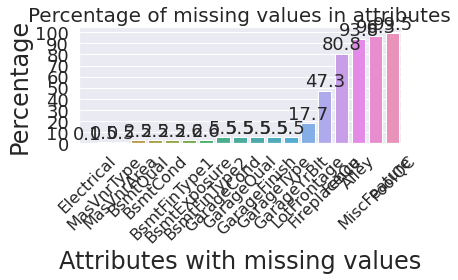

In [11]:
# just some fontsizes
fs1 = 18
fs2 = 24

ypos = np.arange(0,110,10) # creates the list [0,10,20,...,100]
sns.set(rc = {'figure.figsize':(15,8)})
missing_values_pct = [round(i/1460*100, 1) for i in missing_values] # creates a list where that turns the missing values into percentage
ax = sns.barplot(missing_values.index, missing_values_pct) # creates the bar plot
ax.bar_label(ax.containers[0], fontsize=fs1) # add the individual bar values
plt.xticks(rotation = 45, fontsize=16) # rotates the x labels
plt.yticks(ypos, fontsize=fs1) # changes the y to the labels in ypos
plt.title("Percentage of missing values in attributes", fontsize=20) # creates a title for the plot
plt.ylabel("Percentage", fontsize=fs2) # creates a y-label for the plot
plt.xlabel("Attributes with missing values", fontsize=fs2)

plt.tight_layout() # makes everything nice and good looking

plt.savefig(fname="graphs/missing_values_percentage", transparent=True) # saves the figure to the file explore

We deal with the missing values in each attributes in the order they are shown in the graph above (from left to right)

### Electrical

In [12]:
print(data.Electrical.value_counts())
print(data.Electrical.value_counts(normalize=True)*100) # very smart # ;)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
SBrkr    91.432488
FuseA     6.442769
FuseF     1.850583
FuseP     0.205620
Mix       0.068540
Name: Electrical, dtype: float64


In [13]:
# Arguments for giving id 1379 SBrkr SBrkr argument as as Electrical attribute 

ElecCount = 0
ACcount = 0
YearCount = 0
SBrkr2006 = 0
for i in data.index:
    if(data.iloc[i]['Electrical'] == 'SBrkr'):
        ElecCount += 1
        if(data.iloc[i]['CentralAir'] == 'Y'):
            ACcount += 1
    if(data.iloc[i]['YearBuilt'] == 2006):
        YearCount += 1
        if(data.iloc[i]['Electrical'] == 'SBrkr'):
            SBrkr2006 += 1
            
print(ElecCount, ACcount, YearCount, SBrkr2006)
print(f'This means that out of {YearCount} total houses built in 2006, if we disregard id 1379, {int(SBrkr2006/(YearCount-1)*100)}% of the houses has SBrkr electrical system.')
print(f'Out of a total {data.Electrical.value_counts()["SBrkr"]} houses, {round(ACcount/ElecCount*100,2)}% of the houses that has SBrkr electrical system also has aircondition')

1334 1282 67 66
This means that out of 67 total houses built in 2006, if we disregard id 1379, 100% of the houses has SBrkr electrical system.
Out of a total 1334 houses, 96.1% of the houses that has SBrkr electrical system also has aircondition


In [14]:
print(data.iloc[1379]['CentralAir'])
print(data.iloc[1379]['HeatingQC'])
print(data.iloc[1379]['OverallCond'])
print(data.iloc[1379]['YearBuilt'])

Y
Gd
5
2006


id 1379 is the only house that has 'NaN' on the 'Electrical' attribute. By using deductive imputation, we've found that it's probably not the case that it has no electrical system, since it a house built in 2006, it has good heating quality, it has central air conditioning and an overall rating of 5.

We can therefore deduct that the house wouldn't have gotten these scores if it had no electrical system. So the nan value most likely stems from them not knowing that system it has. We therefore give it the SBrkr attribute instead, since it is most likely to be that electrical system it actually has.

### MasVnrType &amp; MasVnrArea

From the figure we see that these two attritues both have 0.5 percent missing values

In [15]:
are_the_number_of_NaN_equal([data.MasVnrType, data.MasVnrArea]) # function call

True

In [16]:
MasVnr_df = data[['MasVnrType', 'MasVnrArea']] # dataframe with only MasVnrType and MasVnrArea
are_entries_with_nan_the_same(MasVnr_df) # function call

All attributes with NaN entries, come frome the same entry


Since all entries that are NaN are in the same columns, we assume that the 8 entries with missing values in regards to MasVnr, are because they are unknown, and thus, we assign this property to the missing values.

In [17]:
data[data.MasVnrType.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,20,RL,67.0,10083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,20,FV,95.0,11639,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,60,RL,75.0,9473,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


Index 773 and 1230 are set to 0 in MasVnrArea because they had 1, so we assume this was giving because they thought 1 was equivalent to 0. 
Furthermore, index 624, 1300, and 1334 was replaced with "Unknown" in MasVnrType because their MasVnrArea was a reasonable number.

In [18]:
data['MasVnrArea'].replace(1,0, inplace=True) # replace the two entries that have only 1 in area with 0
data.loc[[624,1300,1334],'MasVnrType'] = "Unknown" # replace the indexes from None to "Unknown"

The rest of the missing values in the attributes MasVnrType and MasVnrArea are replaced with "Unknown" and 0 respectively. This is seen in the almight fillna() function

### BsmtQual, Bsmtcond, BsmtFinType1, BsmtFinType2, and BsmtExposure

We can see from the graph over percentage missing values, that the attributes describing basement, the attributes BsmtFinType2 and BsmtExposure have 1 more entry with NaN values. Thus we must investigate these entries:

In [19]:
print(are_the_number_of_NaN_equal([data.BsmtQual, data.BsmtCond, data.BsmtFinType1]))
print(are_the_number_of_NaN_equal([data.BsmtFinType2, data.BsmtExposure]))

True
True


In [20]:
bsmt_df = data[['BsmtQual', 'BsmtCond', 'BsmtFinType1']]
bsmt_df1 = data[['BsmtFinType2', 'BsmtExposure']]

are_entries_with_nan_the_same(bsmt_df)
are_entries_with_nan_the_same(bsmt_df1)

All attributes with NaN entries, come frome the same entry
332
948


These are the entries with extra NaN values

In [21]:
data.loc[[332,948]][['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure']]

,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtExposure
332,Gd,TA,GLQ,NaN,No
948,Gd,TA,Unf,Unf,NaN


In [22]:
#shows all the missing values in the attributes with extra NaN values
#data.loc[(data.BsmtExposure.isna()) | (data.BsmtFinType2.isna())][['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure']]

In [23]:
# Replace the odd entries with extra NaN values with appropriate values:
data.loc[948, 'BsmtExposure'] = "No" 
data.loc[332, 'BsmtFinType2'] = "NoBasement" # is maybe redundant

### GarageCond, GarageQual, GarageFinish, GarageType, and GarageYrBlt

In [24]:
are_entries_with_nan_the_same(
    data[['GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'GarageYrBlt']]
)

All attributes with NaN entries, come frome the same entry


Because all entries with NaN values are the same entries, and the data describtion tells us that NaN values are equal to no garage, we replace all NaN values with "NoGarage".

### LotFrontage

We assume that all entries with NaN in the LotFrontage attribute, means that the house doesnt have a lot on the front of the house. See the almighty fillna() function

### FireplaceQu

In the dataset describtion, NaN means that there is no fireplace. 

### Fence

In the dataset describtion, NaN means that there is no fence. 

### Alley

In the dataset describtion, NaN means that there is not access to an alley. 

### MiscFeature

In the dataset describtion, NaN means that there is no miscellaneous features.

### PoolQC

In the dataset describtion, NaN means that there is no pool.

In [25]:
data.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

### Almighty function to replace all NaN values

In [26]:
data.fillna({ 
    'Electrical': "SBrkr", 
    'MasVnrType': "Unknown", 
    'MasVnrArea': 0, 
    'BsmtQual': "NoBasement", 
    'BsmtCond': "NoBasement",
    'BsmtFinType1': "NoBasement",
    'BsmtExposure': "NoBasement",
    'BsmtFinType2': "NoBasement", 
    'GarageCond': "NoGarage",
    'GarageQual': "NoGarage", 
    'GarageFinish': "NoGarage", 
    'GarageType': "NoGarage", 
    'GarageYrBlt': math.floor(np.mean(data.GarageYrBlt)), # adds the average year to the missing columns
    'LotFrontage': 0,
    'FireplaceQu': "NoFireplace",
    'Fence': "NoFence", 
    'Alley':'NoAlleyAccess', 
    'MiscFeature': "None",
    'PoolQC': "NoPool"
}, inplace=True)

## Dealing with Outliers

The dataset documentation describes 4 outliers in the dataset. These can be seen if you compare the SalePrice with the GrLiveArea.

In [27]:
_deepnote_run_altair(raw_data, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"bar","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"GrLivArea","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"SalePrice","type":"quantitative","sort":null,"scale":{"type":"linear","zero":true}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

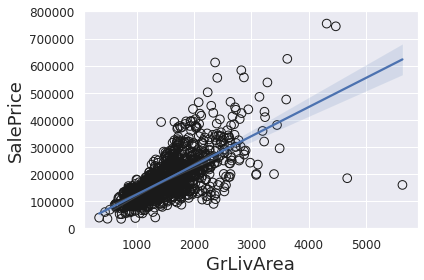

In [28]:
import matplotlib.pyplot as plt

feature = 'GrLivArea'
#plt.scatter(raw_data[feature], raw_data['SalePrice'], facecolors='b', edgecolors='b', s=75)
plt.scatter(raw_data[feature], raw_data['SalePrice'], facecolors='none', edgecolors='k', s=75)
sns.regplot(x=feature, y=raw_data['SalePrice'], data=raw_data, scatter=False, color='b')
ax=plt.gca()
ax.set_ylim([0,800000])
plt.xlabel(feature, fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice', fontsize=18)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(fname="graphs/grlivarea_outliers", transparent=False) # saves the figure to the file explore

Remove the 4 outliers that has a greater GrLivArea than 4000 (index 523, 691,1182,1298)

In [29]:
for i, a in enumerate(data.GrLivArea):
   if a > 4000:
        data.drop(i, inplace=True)

## Renaming features with dumb names

In [30]:
# Features starting with a number is annoying to work with
data.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )

## Encoding categorical variables

Divide the data into categorical features and numerical features, and split categorical into ordinal and nominal features:

In [31]:
nominal_features = ['MSZoning',
                    'Street',
                    'Alley',
                    'LandContour',
                    'LotConfig',
                    'Neighborhood',
                    'Condition1',
                    'Condition2',
                    'BldgType',
                    'HouseStyle',
                    'RoofStyle',
                    'RoofMatl',
                    'Exterior1st',
                    'Exterior2nd',
                    'MasVnrType',
                    'Foundation',
                    'Heating',
                    'GarageType',
                    'MiscFeature',
                    'SaleType',
                    'SaleCondition']

# dict with the order of the ordinal features
ordinal_features_order = {
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["NoBasement","Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["NoBasement","Po", "Fa", "TA", "Gd", "Ex"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "FireplaceQu": ["NoFireplace","Po", "Fa", "TA", "Gd", "Ex"],
    "GarageQual": ["NoGarage","Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["NoGarage","Po", "Fa", "TA", "Gd", "Ex"],
    "PoolQC": ["NoPool","Po", "Fa", "TA", "Gd", "Ex"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["NoBasement","No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["NoBasement","Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["NoBasement","Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["NoGarage","Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["NoFence","MnWw", "GdWo", "MnPrv", "GdPrv"],
}

nominal_data = data[nominal_features]
ordinal_data = data[list(ordinal_features_order.keys())]

# excludes the nominal and ordinal features
numeric_data = data.loc[:, ~data.columns.isin(list(ordinal_features_order.keys())+nominal_features+['SalePrice'])]

The numeric features are already encoded correctly (`float` for
continuous, `int` for discrete), but the categoricals we'll need to
do ourselves. Note in particular, that the `MSSubClass` feature is
read as an `int` type, but is actually a (nominative) categorical.

### One-hot-encoding nominal features

In [32]:
onehotencoder = OneHotEncoder(sparse=False)

ohe_data = onehotencoder.fit_transform(nominal_data) # np array
ohe_nominal_df = pd.DataFrame(ohe_data).astype(int)

### Label-encoding ordinal features

In [33]:
le_ordinal_df = ordinal_data.copy()

# encodes the ordinal features
for i in ordinal_features_order:
    order = ordinal_features_order[i]
    ordinalencoder = OrdinalEncoder(categories=[order])
    le_ordinal_df[i] = ordinalencoder.fit_transform(le_ordinal_df[[i]])

### Concatenate one-hot-encoded dataframe, and save it (not really used)

In [34]:
categorical_ohe_df = pd.concat([ohe_nominal_df.reset_index(), le_ordinal_df.reset_index()], axis=1)

In [35]:
ohe_df = pd.concat([categorical_ohe_df.reset_index(), numeric_data.reset_index()], axis='columns', join='outer')

In [36]:
# Saving the encoded data set

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(ohe_df, data.SalePrice, test_size=0.20, random_state=42)

X_train_enc.to_csv(path_or_buf="dataset_versions/encoded_dataset/X_train_enc.csv", index=False) 
X_test_enc.to_csv(path_or_buf="dataset_versions/encoded_dataset/X_test_enc.csv", index=False) 
y_train_enc.to_csv(path_or_buf="dataset_versions/encoded_dataset/y_train_enc.csv", index=False) 
y_test_enc.to_csv(path_or_buf="dataset_versions/encoded_dataset/y_test_enc.csv", index=False) 

### Label-encoding nominal features

In [37]:
le_nominal_df = data[nominal_features].copy()
labelencoder = LabelEncoder()

# Label encodes all the nominal features
for column in le_nominal_df[nominal_features]:
    le_nominal_df[column] = labelencoder.fit_transform(le_nominal_df[column])

In [38]:
le_cat_df = pd.concat([le_nominal_df, le_ordinal_df], axis='columns', join='outer')

In [39]:
le_df = pd.concat([le_cat_df, numeric_data], axis='columns', join='outer')
le_df['SalePrice'] = data.SalePrice
le_df.shape

(1456, 80)

In [40]:
le_df.to_csv(path_or_buf="dataset_versions/label_encoded_data.csv", index=False) 
le_df.shape

(1456, 80)

In [41]:
# function for label-encoding a dataframe
# df: dataframe
# nominal_features: list of nominal features in the dataframe
# ordinal_feature_order: dictionary with the order of the ordinal features

def encode(df, nominal_features, ordinal_feature_order):
    X = df.copy()

    # Ordinal encode ordinal features
    for i in ordinal_feature_order:
        order = ordinal_features_order[i] # gets the correct order for the ith feature
        ordinalencoder = OrdinalEncoder(categories=[order]) # creates OrdinalEncoder object with correct order
        X[i] = ordinalencoder.fit_transform(X[[i]]) # ordinal encode the ith column

    # Label encode all the nominal features
    labelencoder = LabelEncoder() # instanciates a label-encoder object
    for i in X[nominal_features]:
        X[i] = labelencoder.fit_transform(X[i])
        
    return X # returns the encoded dataframe


In [42]:
test = pd.read_csv("/work/ames_housing_dataset/test.csv")

test_id = pd.DataFrame(test.pop("Id"))

test.fillna({ 
    'Electrical': "SBrkr", 
    'MasVnrType': "Unknown", 
    'MasVnrArea': 0, 
    'BsmtQual': "NoBasement", 
    'BsmtCond': "NoBasement",
    'BsmtFinType1': "NoBasement",
    'BsmtExposure': "NoBasement",
    'BsmtFinType2': "NoBasement", 
    'GarageCond': "NoGarage",
    'GarageQual': "NoGarage", 
    'GarageFinish': "NoGarage", 
    'GarageType': "NoGarage", 
    'GarageYrBlt': math.floor(np.mean(data.GarageYrBlt)), # adds the average year to the missing columns
    'LotFrontage': 0,
    'FireplaceQu': "NoFireplace",
    'Fence': "NoFence", 
    'Alley':'NoAlleyAccess', 
    'MiscFeature': "None",
    'PoolQC': "NoPool"
}, inplace=True)

test.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )

test = test.fillna(method='ffill')

test = encode(test, nominal_features, ordinal_features_order)


test['Id'] = test_id

test

test.to_csv(path_or_buf="dataset_versions/kaggle_test.csv", index=False) 

## Scaling data (standardisation / min-max scaling)

In [43]:
X = data.copy()
y = X.pop('SalePrice')
numeric_columns = X.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

We standardise the numerical the data with the following formula:

$$z=\frac{x-\mu}{\sigma}$$ \
$$\mu = mean$$ \
$$\sigma = \text{standard deviation}$$

Using the `StanardScaler()` (`from sklearn.preprocessing import StandardScaler`), adjust the mean of the features to be 0 and the standard deviation to 1 (thus getting a normal distribution of the data in each feature)

In [44]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler() # ScikitLearn minmax scaler object
standard_scaler.fit(X[numeric_columns])
standardised_df = pd.DataFrame(standard_scaler.transform(X[numeric_columns])) # normalised to 0-1
standardised_df.set_axis(numeric_columns, axis=1, inplace=True) # puts the column names back (because they for some reason disapeared)

<AxesSubplot:xlabel='LotFrontage', ylabel='Count'>

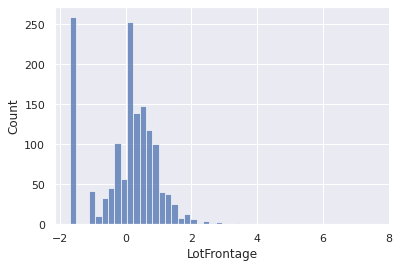

In [45]:
sns.histplot(standardised_df.LotFrontage)

We can also use Scikit-learn's `MinMaxScaler` to scale the numerical features to between 0-1

## Save and divide the data into training and test

In [46]:
# save the dataset with 0 missing values
data.to_csv(path_or_buf="dataset_versions/dataset_no_missing_values.csv", index=False) 

In [47]:
test = data.SalePrice
train = data.copy().drop("SalePrice",axis="columns")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.30)

X_train.to_csv(path_or_buf="dataset_versions/splitted_dataset_without_missing_values/X_train.csv", index=False) 
X_test.to_csv(path_or_buf="dataset_versions/splitted_dataset_without_missing_values/X_test.csv", index=False) 
y_train.to_csv(path_or_buf="dataset_versions/splitted_dataset_without_missing_values/y_train.csv", index=False) 
y_test.to_csv(path_or_buf="dataset_versions/splitted_dataset_without_missing_values/y_test.csv", index=False) 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a79dfa2f-1b6b-4b40-b0ca-7dec9e2a123f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>